In [2]:
# descargar librerias necesarias
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 38.6 MB/s eta 0:00:00m eta 0:00:0136m0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 KB 7.4 MB/s eta 0:00:00m eta 0:00:01


### Ejecutar celda para seguir el notebook:

In [1]:
from pyspark.sql import SparkSession

from pyspark.sql.functions import dayofweek, dayofmonth, weekofyear, month, year

import matplotlib.pyplot as plt
import pandas as pd


spark = SparkSession.builder.getOrCreate()

data_path = "datos/sample_10e3.json"
df = spark.read.json(data_path)

23/05/25 11:02:36 WARN Utils: Your hostname, pclab032 resolves to a loopback address: 127.0.1.1; using 147.96.132.249 instead (on interface eno1)
23/05/25 11:02:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/25 11:02:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
df.columns

['_id',
 'ageRange',
 'idplug_base',
 'idplug_station',
 'idunplug_base',
 'idunplug_station',
 'travel_time',
 'unplug_hourTime',
 'user_day_code',
 'user_type',
 'zip_code']

# Idea 1. Pruebas para el conteo de cuantas bicis se desenganchan de un sitio vs cuántas se enganchan

Agrupamos los datos por los ids de las estaciones. Un dataframe con los plugs y otro con los un_plugs, y los contamos. Luego los unimos con un join con respecto al id. Así podemos ver comparar en cada estación cuantos ha habido de cada.

In [120]:
df1 = df.groupBy('idunplug_station').count()

In [121]:
df2 = df.groupBy('idplug_station').count()

In [122]:
# renombrar las columnas para unirlas
df1 = df1.withColumnRenamed('idunplug_station', 'id').withColumnRenamed('count', 'n_unplugs')
df2 = df2.withColumnRenamed('idplug_station', 'id').withColumnRenamed('count', 'n_plugs')

In [123]:
df3 = df1.join(df2, on='id')

In [124]:
df3

DataFrame[id: bigint, n_unplugs: bigint, n_plugs: bigint]

In [125]:
df3.show()

+---+---------+-------+
| id|n_unplugs|n_plugs|
+---+---------+-------+
| 26|       12|     10|
| 29|        1|      1|
| 65|        8|      7|
| 54|        8|      8|
| 19|       17|      5|
|155|        2|     17|
|113|        4|      1|
|167|        9|      2|
|130|        3|      1|
| 77|        3|     13|
|  7|        8|      2|
| 34|        1|      4|
|126|        3|     10|
| 94|        3|      2|
|149|       10|     21|
| 50|        4|      3|
|190|        2|      5|
|110|        7|      1|
|136|        9|     22|
| 57|       34|     27|
+---+---------+-------+
only showing top 20 rows



 - **limit(10)**: Limitar a solo 10 estaciones (pàra que se vea en el plot)
 - **toPandas()**: para pasarlo a un pandas dataframe y poder plotear

<AxesSubplot:title={'center':'Visualización de la demanda de las estaciones'}, xlabel='id'>

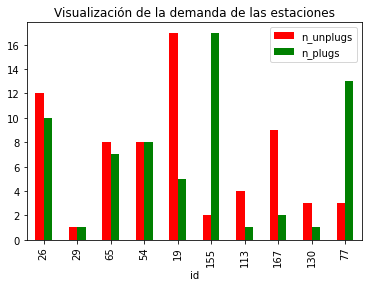

In [128]:
df3.limit(10).toPandas().plot.bar(
    x='id', 
    y=['n_unplugs','n_plugs'], 
    color=['red','green'],
    title="Visualización de la demanda de las estaciones"
)

Vamos ordenar ahora por la resta de ambas demandas. Así podemos ver qué estaciones quitan más bicis y luego no vuelven.

In [157]:
df.count()

1000

# Idea 2. Los jovenes usan más la bici?

In [81]:
tiempo_total = df.groupBy('ageRange')\
                                .sum('travel_time')\
                                .withColumnRenamed("sum(travel_time)", "total")\
                                .orderBy('ageRange')

tiempo_medio = df.groupBy('ageRange')\
                                .mean('travel_time')\
                                .withColumnRenamed("avg(travel_time)", "mean")\
                                .orderBy('ageRange')

In [88]:
tiempos = tiempo_total.join(tiempo_medio, on="ageRange").orderBy("ageRange")
tiempos.show()

+--------+------+------------------+
|ageRange| total|              mean|
+--------+------+------------------+
|       0|465023| 947.0936863543789|
|       1| 20765|1092.8947368421052|
|       2|  8102| 675.1666666666666|
|       3| 62021| 826.9466666666667|
|       4|239544| 897.1685393258427|
|       5|103866| 792.8702290076336|
|       6|  4914|             982.8|
+--------+------+------------------+



Tener en cuenta que aquí estoy pasando a pandas un dataframe muy pequeño (pues ya tiene totas las sumas de los muchos valores de grande) así que la operación no es costosa

<AxesSubplot:title={'center':'Tiempo medio por rango de edades'}, xlabel='ageRange'>

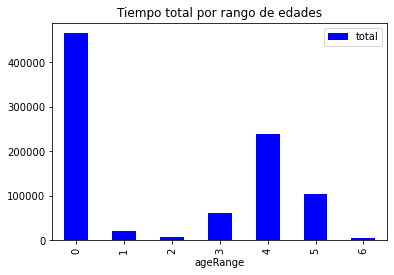

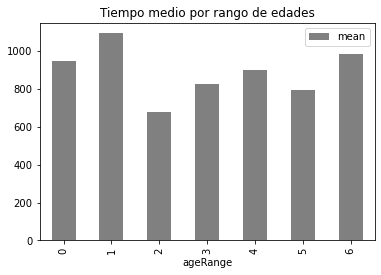

In [90]:
tiempos.toPandas().plot.bar(x="ageRange", y="total", color="blue", title="Tiempo total por rango de edades")
tiempos.toPandas().plot.bar(x="ageRange", y="mean", color="gray", title="Tiempo medio por rango de edades")

Parece que el tiempo medio de uso es muy parecido, pero el conjunto de datos de prueba es muy pequeño por lo que no es concluyente. Por otro lado, en su totalidad sí que se aprecia gran diferencia en los timepos de uso. Parece que el rango de edades 4 lo usa mucho más que los demás.

# Idea 3. Demanda por zonas.

En relación a la separación por zonas anteior (clustering de las estaciones). Podemos observar individualmente la actividad de cada uno. Por ejemplo, guardar cuantas bicis salen de esa zona al día y además ver a dónde van. Para ello creamos dos nuevas columnas (para discretizar), donde guardamos los plugs y unplugs pero en vez de por estaciones, por grupos de estaciones:

 - 'idunplug_station_group'
 - 'idplug_station_group'

luego para hacer el estudio completo agrupamos los datos por dias, es decir, guardamos como una tabla con los datos (salida desde la base hasta luegares de destino) de todos los lunes, martes,... Así podremos ver que días se separan más de la media. Es decir, si los sabados y domingos en un lado tiene una demanda mucho menor de lo habitual en una zona, y por el contrario en otra sube. Ahí es donde buscamos hacer los cambios. Para esto nuevo tendremos que crear un columna, 'day', con el dato: día de la semana (se puede sacar con un lambda de la parte de la fecha).

In [19]:
df.columns

['_id',
 'ageRange',
 'idplug_base',
 'idplug_station',
 'idunplug_base',
 'idunplug_station',
 'travel_time',
 'unplug_hourTime',
 'user_day_code',
 'user_type',
 'zip_code']

In [46]:
df.select('unplug_hourTime')

DataFrame[unplug_hourTime: struct<$date:string>]

### Pruebas pequeñas con un Pandas Dataframe para ver cómo se añadiría las columnas "date" y "hour"

In [27]:
df_date = df.select('unplug_hourTime').limit(3).toPandas()

In [28]:
df_date

,unplug_hourTime
0,"(2019-06-01T00:00:00.000+0200,)"
1,"(2019-06-01T00:00:00.000+0200,)"
2,"(2019-06-01T00:00:00.000+0200,)"


In [39]:
df_date['day'] = df_date['unplug_hourTime'].apply(lambda x : x[0].split("T")[0])
df_date['hour'] = df_date['unplug_hourTime'].apply(lambda x : x[0].split("T")[1])

In [40]:
df_date

,unplug_hourTime,day,hour
0,"(2019-06-01T00:00:00.000+0200,)",2019-06-01,00:00:00.000+0200
1,"(2019-06-01T00:00:00.000+0200,)",2019-06-01,00:00:00.000+0200
2,"(2019-06-01T00:00:00.000+0200,)",2019-06-01,00:00:00.000+0200


### Probar con un SQL Dataframe

In [9]:
df_date2 = df.select('unplug_hourTime').limit(3)

Parece que el dato *date* está encriptado en un tipo 

struct<$date:string> 

por lo que primero tenemos que acceder al primer (y único) elemento $date, con la función 

.getItem("$date") 

y luego ya de ahí podemos consiguir el month, day o lo que sea con las funciones de **pyspark.sql.functions**

In [13]:
from pyspark.sql.functions import dayofmonth, month, year

In [11]:
df_date2.withColumn("day", dayofmonth(df_date2.unplug_hourTime.getItem("$date")))\
            .withColumn("month", month(df_date2.unplug_hourTime.getItem("$date")))\
            .withColumn("year", year(df_date2.unplug_hourTime.getItem("$date"))).show()

+--------------------+---+-----+----+
|     unplug_hourTime|day|month|year|
+--------------------+---+-----+----+
|{2019-06-01T00:00...|  1|    6|2019|
|{2019-06-01T00:00...|  1|    6|2019|
|{2019-06-01T00:00...|  1|    6|2019|
+--------------------+---+-----+----+



genial! parece que podemos conseguir fácilmente esos datos sin necesidad de hacer funciones en strings

In [12]:
df_date2

DataFrame[unplug_hourTime: struct<$date:string>]

podemos ver que **withColumn** no hace inplace en el DataFrame, por lo que tendremos que asignarlo a uno

### Pruebas con clustering y pyspark

Antes tendríamos que pasar las estaciones a tuplas en el mapa. Luego esos datos los ponemos en la columna 'standardized' y así ya compilamos (algo parecido al) algoritmo siguiente. Que simplemente nos devuelve grupos de estaciones. Podemos ver un ejemplo de Clustering y KMeans en:

https://towardsdatascience.com/k-means-clustering-using-pyspark-on-big-data-6214beacdc8b

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score = []

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo = KMeans(featuresCol='standardized', k=i)
    
    KMeans_fit = KMeans_algo.fit(data_scale_output)
    
    output = KMeans_fit.transform(data_scale_output)
    
    
    
    score = evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

In [ ]:
#Visualizing the silhouette scores in a plot

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel(‘k’)
ax.set_ylabel(‘cost’)

### Vamos a hacer las pruebas sin separación por zonas, teniendo en cuenta solo las estaciones y luego ya vemos si hago lo del clustering

 - prepocesamiento de las fechas: cambiar la columna 'unplug_hourTime' por los datos separados


In [6]:
from pyspark.sql.functions import dayofweek, dayofmonth, weekofyear, month, year

Creamos las siguientes columnas:
 - **dayofweek**: para obtener el día de la semana (lunes, martes, ) ya que queremos hacer el estudio sobre esos días.
 - **weekofyear**: para poder ordenar los días, ya que si solo sabemos que es un viernes, no podremos saber cuál exactamente.
 - **year**: dato más general para distinguir el estudio por años.
        

In [16]:
df2 = df.withColumn("dayofweek", dayofweek(df.unplug_hourTime.getItem("$date")))\
            .withColumn("weekofyear", weekofyear(df.unplug_hourTime.getItem("$date")))\
            .withColumn("year", year(df.unplug_hourTime.getItem("$date")))\
            .drop('unplug_hourTime')

In [7]:
def preprocess_dates(df):
    df2 = df.withColumn("dayofweek", dayofweek(df.unplug_hourTime.getItem("$date")))\
            .withColumn("weekofyear", weekofyear(df.unplug_hourTime.getItem("$date")))\
            .withColumn("year", year(df.unplug_hourTime.getItem("$date")))\
            .drop('unplug_hourTime')
    return df2

In [19]:
estudio_por_dias_y_zonas = df.groupBy('idunplug_station')\
                                .groupBy('dayofweek')\
                                .groupBy('idplug_station')\
                                .count()

AttributeError: 'GroupedData' object has no attribute 'groupBy'

Parece que no podemos hacer multiples groupBy ...

Sin embargo, podemos hacer un groupBy multiple, que funciona similar a la idea que queremos. Es decir, al hacer el conteo, cada fila tendrá en cuenta el número de apariciones iguales que le hemos posado al groupBy multiple, y de ahí ya nosotros interpretamos.

In [44]:
df_grouped = df2.groupBy('idunplug_station', 'dayofweek', 'idplug_station').count().orderBy('idunplug_station')

In [45]:
df_grouped.show()

+----------------+---------+--------------+-----+
|idunplug_station|dayofweek|idplug_station|count|
+----------------+---------+--------------+-----+
|               1|        7|            74|    1|
|               1|        7|           106|    1|
|               1|        7|           136|    1|
|               1|        7|            75|    4|
|               1|        7|            50|    1|
|               1|        7|            52|    1|
|               1|        7|           135|    2|
|               1|        7|           105|    1|
|               1|        7|           129|    1|
|               1|        7|           163|    1|
|               1|        7|            90|    1|
|               1|        7|            83|    3|
|               2|        7|           114|    1|
|               2|        7|           170|    1|
|               2|        7|            79|    1|
|               2|        7|            67|    2|
|               2|        7|           149|    1|


Podemos observar que la mayoría de conteos son 1! Esto es devido a que estamos dividiendo el dataframe mucho, tenemos que los conteos son mínimos. Por lo que necesitamos muchos más datos para tener resultados razonables.

### Pruebas con el json grande (de prueba -> tam = 10⁴). Aunque para tampoco llenar la memoria filtraremos por un par de estaciones para ver resultados.

In [13]:
data_path = "datos/sample_10e4.json"

In [31]:
df4 = spark.read.json(data_path)

In [79]:
df4.count()

10000

In [80]:
# observamos varias estaciones y cuantos datos tiene cada una para escoger (para las pruebas) 
# los que más datos tengan
df4.groupBy('idplug_station').count().orderBy('count').tail(5)

[Row(idplug_station=163, count=129),
 Row(idplug_station=129, count=132),
 Row(idplug_station=43, count=138),
 Row(idplug_station=57, count=142),
 Row(idplug_station=135, count=160)]

In [6]:
df4 = df4.filter(
    (df4.idplug_station == 129) | 
    (df4.idplug_station == 163) | 
    (df4.idplug_station == 43)  | 
    (df4.idplug_station == 57)  | 
    (df4.idplug_station == 135)
)

Comprobamos que hemos seleccionado los ids correctos y observamos con cuántos datos nos hemos quedado

In [7]:
df4.select('idplug_station').distinct().show()

+--------------+
|idplug_station|
+--------------+
|            57|
|            43|
|           163|
|           135|
|           129|
+--------------+



In [8]:
df4.count()

701

In [15]:
df4 = preprocess_dates(df4)

In [16]:
estudio_por_dias_y_zonas = df4.groupBy('idunplug_station', 'dayofweek', 'idplug_station')\
                                                                .count().orderBy('idunplug_station')

In [19]:
estudio_por_dias_y_zonas.orderBy('count').tail(10)

[Row(idunplug_station=82, dayofweek=7, idplug_station=57, count=2),
 Row(idunplug_station=84, dayofweek=7, idplug_station=129, count=2),
 Row(idunplug_station=57, dayofweek=4, idplug_station=57, count=3),
 Row(idunplug_station=38, dayofweek=5, idplug_station=129, count=3),
 Row(idunplug_station=45, dayofweek=1, idplug_station=57, count=3),
 Row(idunplug_station=133, dayofweek=7, idplug_station=135, count=3),
 Row(idunplug_station=1, dayofweek=5, idplug_station=43, count=3),
 Row(idunplug_station=160, dayofweek=2, idplug_station=163, count=3),
 Row(idunplug_station=27, dayofweek=3, idplug_station=135, count=3),
 Row(idunplug_station=135, dayofweek=3, idplug_station=135, count=3)]

Podemos ver como seguimos sin tener muchos datos, la verdad que el número máximo es 3, esto también es devido a que estamos contando lo siguiente:
    
**Cuántas veces se va desde una estación i a otra j el día x.**

Teniendo en cuenta que hay muchas estaciones, las veces que estos datos coinciden son pocas, teniendo en cuenta la cantidad de datos al que tenemos acceso (10.000) no son tantos. Por tanto a lo mejor unir varias estaciones por zonas no es mala idea, para obtener mejores resultados. Además cuando hagamos las pruebas finales con datos de varios años tendremos mejores resultados.

Por ejemplo, contemos cuántas estaciones tenemos en nuestros datos:

In [95]:
df4.select('idunplug_station').distinct().count()

157

### Veamos qué podemos hacer con las estaciones. Parece que se nos proporciona un archivo .geo con las localizaiciones. Así que tocará cargarlo de alguna manera y añadirlo al dataframe con su localización.

In [63]:
!pip install xlrd

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 KB 1.4 MB/s eta 0:00:00 MB/s eta 0:00:01


Esto lo hacemos en otro jupyter, ya que se hacen muchas pruebas e instalaciones...

Al final conseguimos los datos! Otro día sigo

In [64]:
geo = pd.read_excel('datos/bases_bicimad.xls')

In [22]:
geo.head()

,Número,Gis_X,Gis_Y,Fecha de Alta,Distrito,Barrio,Calle,Nº Finca,Tipo de Reserva,Número de Plazas,Longitud,Latitud,Direccion
0,001 a,440443.61,4474290.65,43803,01 CENTRO,01-06 SOL,"ALCALA, CALLE, DE",2,BiciMAD,30,-3.701998,40.417111,"ALCALA, CALLE, DE, 2"
1,001 b,440480.56,4474301.74,43867,01 CENTRO,01-06 SOL,"ALCALA, CALLE, DE",6,BiciMAD,30,-3.701564,40.417213,"ALCALA, CALLE, DE, 6"
2,2,440134.83,4474678.23,41813,01 CENTRO,01-05 UNIVERSIDAD,"MIGUEL MOYA, CALLE, DE",1,BiciMAD,24,-3.705674,40.420580,"MIGUEL MOYA, CALLE, DE, 1"
3,3,440012.98,4475760.68,41813,07 CHAMBERÍ,07-02 ARAPILES,"CONDE DEL VALLE DE SUCHIL, PLAZA, DEL",2,BiciMAD,18,-3.707212,40.430322,"CONDE DEL VALLE DE SUCHIL, PLAZA, DEL, 2"
4,4,440396.40,4475565.36,41813,01 CENTRO,01-05 UNIVERSIDAD,"MANUELA MALASAÑA, CALLE, DE",3,BiciMAD,24,-3.702674,40.428590,"MANUELA MALASAÑA, CALLE, DE, 3"


In [32]:
print("Numero de estaciones distintas:", df4.select('idunplug_station').distinct().count())
print("Numero de barrios distintos:", len(set(geo['Barrio'].to_list())))

Numero de estaciones distintas: 173
Numero de barrios distintos: 60


In [39]:
geo[['Número','Barrio']]

,Número,Barrio
0,001 a,01-06 SOL
1,001 b,01-06 SOL
2,2,01-05 UNIVERSIDAD
3,3,07-02 ARAPILES
4,4,01-05 UNIVERSIDAD
...,...,...
264,257,09-03 CIUDAD UNIVERSITARIA
265,258,09-03 CIUDAD UNIVERSITARIA
266,259,09-03 CIUDAD UNIVERSITARIA
267,260,09-03 CIUDAD UNIVERSITARIA


In [65]:
codes = geo.set_index("Número")["Barrio"].to_dict()

In [46]:
codes.keys()

dict_keys(['001 a', '001 b', 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, '020 ampliacion', 22, 23, 24, '025 a', '025 b', 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, '080 a', '080 b', 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, '090 ampliacion', 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, '106 a', '106 b', 107, 108, 109, 110, '111 a', '111 b', 112, 113, 114, 115, '116 a', '116 b', 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, '128 ampliacion', 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, '140 ampliación', 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, '161 ampliacion', 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 18

Observamos que los números de las estaciones vienen o bien como un entero o bien como una string la cual nos dice algún dato más como 'a' o 'b', o si es una ampliación.
Así podemos distinguir unpar de casos y ya.

Vamos a intentar conseguir una columna en la tabla grande que nos diga de que barrio es. Para ello reiniciamos todo el preproceso de df4.

In [14]:
df4 = spark.read.json(data_path)

In [15]:
print("nº de columnas:", len(df4.columns))
print("nº de filas:", df4.count())

nº de columnas: 12
nº de filas: 10000


In [85]:
def get_barrio(e):
    return codes[e]

In [58]:
df4.withColumn(get_barrio(df4.idunplug_station))

TypeError: unhashable type: 'Column'

Obviamente no ibamos a poder meter una función así tal cual a un dataframe para ello tenemos que primero pasarlo a un rdd y luego volve. 

Veamos con un dataframe pequeño de prueba:

In [17]:
df_rdd = df4.select(["ageRange", "idunplug_station", "idplug_station"]).limit(3)

In [18]:
rdd = df_rdd.rdd

In [41]:
rdd.collect()

[Row(ageRange=4, idunplug_station=111, idplug_station=58),
 Row(ageRange=4, idunplug_station=40, idplug_station=90),
 Row(ageRange=4, idunplug_station=136, idplug_station=172)]

In [45]:
type(rdd.collect()[0])

pyspark.sql.types.Row

In [47]:
row = rdd.collect()[0]

In [52]:
row.ageRange

4

Comentario: Parece que para mantener el rdd con los nombres tendremos que usar el tipo Row (anterior) para así después poder pasarlo al DataFame cómodamente. Documentación en: https://hyukjin-spark.readthedocs.io/en/latest/reference/api/pyspark.sql.types.Row.html

In [46]:
from pyspark.sql.types import Row

Pequeña pueba para añadir columnas:

In [57]:
create_row = lambda x, new : Row(ageRange=x[0], idunplug_station=x[1], idplug_station=x[2], id_new=new)

In [58]:
rdd2 = rdd.map(lambda x : create_row(x, 999))

In [59]:
rdd2.collect()

[Row(ageRange=4, idunplug_station=111, idplug_station=58, id_new=999),
 Row(ageRange=4, idunplug_station=40, idplug_station=90, id_new=999),
 Row(ageRange=4, idunplug_station=136, idplug_station=172, id_new=999)]

Perfe! Ahora ya podemos aplicar lo función transformación

In [104]:
# cambiamos un poco la función get barrio ya que se ha podido modificar a lo largo del tiempo, 
# si nos da un error seguramente es que se halla añadido un a nueva base en la zona, por lo que 
# la llamaremos como "{numero} a"
def get_barrio(e):
    try:
        c = codes[e]
    except:
        new_e = str(e) + " a"
        c = codes[new_e]
    finally:
        return c

In [110]:
def map_barrio(x):
    plug = get_barrio(x.idunplug_station)
    unplug = get_barrio(x.idunplug_station)
    return Row(ageRange=x.ageRange, idunplug_barrio=unplug, idplug_barrio=plug)

In [102]:
rdd2 = rdd.map(map_barrio)

In [103]:
rdd2.collect()

[Row(ageRange=4, idunplug_barrio='07-01 GAZTAMBIDE', idplug_barrio='07-01 GAZTAMBIDE'),
 Row(ageRange=4, idunplug_barrio='01-02 EMBAJADORES', idplug_barrio='01-02 EMBAJADORES'),
 Row(ageRange=4, idunplug_barrio='05-01 EL VISO', idplug_barrio='05-01 EL VISO')]

In [105]:
df_new = rdd2.toDF()

In [106]:
df_new

DataFrame[ageRange: bigint, idunplug_barrio: string, idplug_barrio: string]

Genial! Ya podemos cambiar el nombre de las estaciones por el barrio. Se podría pensar en mapear el nombre de los barrios números enteros, pero tampoco es que cambie mucho. De todas formas dicho cambio es sencillo. Por ahora lo voy a dejar con los nombre para que sea más visible.